# Regional Model Comparisons with SCA_Image (Input) and CATDEF (Target) using ConvLSTM2D

In [8]:
# !pip3 install pickle5
# !pip install tqdm
import tqdm
import pickle5 as pickle
import matplotlib as mpl
import pandas as pd
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot

from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling3D
from numpy import zeros, newaxis

from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LinearRegression

import seaborn as sns
import pylab as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

import io
from PIL import Image
from io import StringIO

import time
from tqdm import tqdm
from time import sleep

from IPython.display import clear_output

pd.options.mode.chained_assignment = None  # default='warn'

start_time = time.time()

In [20]:
seed = 1234
np.random.seed(seed)
tf.random.set_random_seed(seed)

In [3]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.compat.v1.Session(config=config)

# Set run variables here

In [6]:
train_models = 11  # value of 0 through 10 to train corresponding model, set >10 to train no models (can only train one model at a time before resetting kernel due to memory exhaustion)
save_models = 1
compile_predictions = 1
overwrite_ensemble_output = 1
second_feature = 'evap'
stop = 0
# train_base_model = 0
# save_summaries = 1
multi_features = 1 
# use_mask_for_testing = 0
#how many months to offset selected columns
offset = 0
#region to leave unmasked
region = 2
region_mask_column = 'catdef_region_' + str(region)
train_size = 123
model_names = ['original_model', 'base_model', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_10']

#replace masked cells with 0 or None
mask_replace = None
# # determines whether Y_train includes masked 0s or is reduced in size (dimension)
# reduce_y = 1
epochs = 500


# Resize SCA image to 256x256 to avoid Out-of-Memory issues.
img_height = 128
img_width = 128
IMAGE_SHAPE = (1, 128,128, 4)

In [7]:
region_mask = pd.read_csv('data/Region_mask.csv').to_numpy()
flat_mask = region_mask.flatten().tolist()
region_list = range(1,11)

In [23]:
path = './data/all_data_with_catdef_masks.pkl'
with open(path, "rb") as fh:
  data = pickle.load(fh)
# all_data_df = pd.read_pickle('./data/all_data.pkl')
# now_with_predictions = data.copy()
all_data_df = data.copy(deep=True)
test_months = np.arange(train_size, len(all_data_df), 1)
#reindex Month column for clarity
all_data_df['Month'] =  np.arange(0, len(all_data_df), 1)
all_data_df = all_data_df.rename(columns={"Month": "Data_month"})
all_data_df.iloc[:,:20][122:124]

,Year,Data_month,SCA,Landsat_Image,BW_SCA_Image,Color_SCA_Image,CA_catdef,catdef,catdef_region_1,catdef_region_2,catdef_region_3,catdef_region_4,catdef_region_5,catdef_region_6,catdef_region_7,catdef_region_8,catdef_region_9,catdef_region_10,rzexc,evap
122,2013,122,43038753,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 72.395, 100.64, 113.99, 129.0...","[[nan, nan, nan, 72.395, 100.64, 113.99, 129.0...","[[nan, nan, nan, 72.395, 100.64, 113.99, 129.0...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, 1.5935, 1.3338, 0.90994, 0.42...","[[nan, nan, nan, 1.8675, 1.8954, 1.7113, 1.739..."
123,2013,123,59089132,<PIL.Image.Image image mode=RGB size=480x480 a...,<PIL.Image.Image image mode=1 size=570x660 at ...,<PIL.Image.Image image mode=RGBA size=570x660 ...,"[[nan, nan, nan, 85.939, 109.03, 122.28, 143.5...","[[nan, nan, nan, 85.939, 109.03, 122.28, 143.5...","[[nan, nan, nan, 85.939, 109.03, 122.28, 143.5...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, 0.7728, 0.45347, 0.17026, -0....","[[nan, nan, nan, 2.6161, 2.6248, 2.5975, 2.507..."


In [7]:
all_data_df.columns

Index(['Year', 'Data_month', 'SCA', 'Landsat_Image', 'BW_SCA_Image',
       'Color_SCA_Image', 'CA_catdef', 'catdef', 'catdef_region_1',
       'catdef_region_2', 'catdef_region_3', 'catdef_region_4',
       'catdef_region_5', 'catdef_region_6', 'catdef_region_7',
       'catdef_region_8', 'catdef_region_9', 'catdef_region_10', 'rzexc',
       'evap', 'srfexc', 'sfmc', 'capac', 'Snowf', 'Rainf', 'prmc', 'sumwesn',
       'runoff', 'Tair', 'RainfC', 'rzmc'],
      dtype='object')

In [7]:
test_months

array([123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167])

In [9]:
all_data_df.columns

Index(['Year', 'Data_month', 'SCA', 'Landsat_Image', 'BW_SCA_Image',
       'Color_SCA_Image', 'CA_catdef', 'catdef', 'catdef_region_1',
       'catdef_region_2', 'catdef_region_3', 'catdef_region_4',
       'catdef_region_5', 'catdef_region_6', 'catdef_region_7',
       'catdef_region_8', 'catdef_region_9', 'catdef_region_10', 'rzexc',
       'evap', 'srfexc', 'sfmc', 'capac', 'Snowf', 'Rainf', 'prmc', 'sumwesn',
       'runoff', 'Tair', 'RainfC', 'rzmc'],
      dtype='object')

In [10]:
# #Load saved predictions from previous runs (.pkl file)
# if multi_features == 0:
#     path = './data/all_predictions.pkl'
# if multi_features == 1:
#     path = './2_input_data/all_predictions.pkl'
# with open(path, "rb") as fh:
#   loaded_predictions = pickle.load(fh)
# loaded_predictions.tail(5)

In [11]:
# path = './2_input_data/predictions_plus_mixed.pkl'
# with open(path, "rb") as fh:
#   loaded_predictions_full = pickle.load(fh)
# loaded_predictions_full.tail(5)    

In [12]:
# data['sum_of_regions'] = (data['catdef_region_1'].apply(lambda x: np.sum(np.nan_to_num(x, nan = 0))) + data['catdef_region_2'].apply(lambda x: np.sum(np.nan_to_num(x, nan = 0))) 
#                           + data['catdef_region_3'].apply(lambda x: np.sum(np.nan_to_num(x, nan = 0))) + data['catdef_region_4'].apply(lambda x: np.sum(np.nan_to_num(x, nan = 0)))
#                           + data['catdef_region_5'].apply(lambda x: np.sum(np.nan_to_num(x, nan = 0))) + data['catdef_region_6'].apply(lambda x: np.sum(np.nan_to_num(x, nan = 0)))
#                           + data['catdef_region_7'] + data['catdef_region_8'].apply(lambda x: np.sum(np.nan_to_num(x, nan = 0))) + data['catdef_region_9'].apply(lambda x: np.sum(np.nan_to_num(x, nan = 0)))
#                           + data['catdef_region_10'].apply(lambda x: np.sum(np.nan_to_num(x, nan = 0))))
# catdef_df = pd.DataFrame(data['sum_of_regions'])
# catdef_df['sum'] = catdef_df['sum_of_regions'].apply(lambda x: np.sum(np.nan_to_num(x, nan = 0)))
# catdef_df

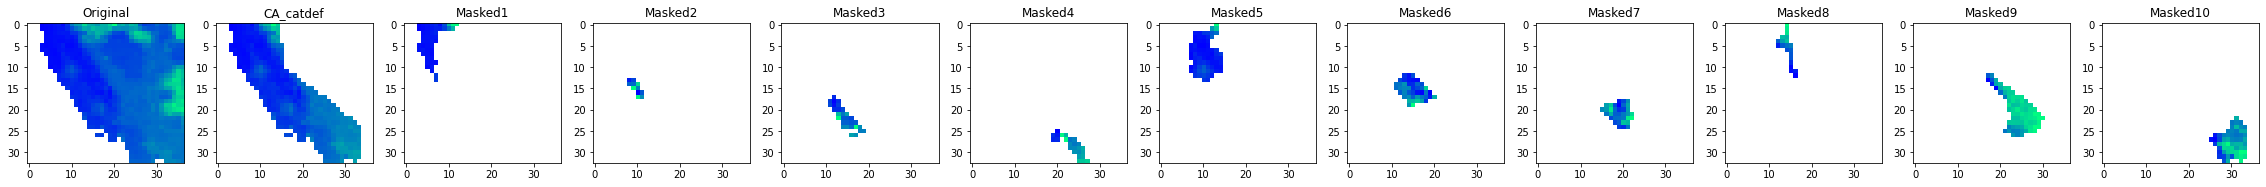

In [20]:
fig = plt.figure(figsize=(40,4))

plt.subplot(1,12,1)
plt.title('Original')
plt.imshow(all_data_df['catdef'][0], cmap = 'winter')

plt.subplot(1,12,2)
plt.title('CA_catdef')
plt.imshow(all_data_df['CA_catdef'][0], cmap = 'winter')

for i in range(3,13):
    msk_rg = 'catdef_region_' + str(i-2)
    plt.subplot(1,12,i)
    plt.title('Masked' + str(i-2))
    plt.imshow(all_data_df[msk_rg][0], cmap = 'winter')

In [25]:
region_sizes = []
for i in range(1,11):
    matches = region_mask[region_mask == i]
    region_sizes.append(len(matches))
    print(i, ":",  len(matches))

1 : 52
2 : 11
3 : 30
4 : 25
5 : 76
6 : 46
7 : 36
8 : 21
9 : 81
10 : 62


## Functions    <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

In [26]:
def general_plot(plotlist, cmap = 'winter'):
    fig = plt.figure(figsize=(4,4))
    if len(plotlist) > 33:
        plotlist = np.array(plotlist).reshape(33,37)

    plt.imshow(plotlist, cmap = cmap)

In [27]:
def dual_plot(pred, actual):
    if len(pred) > 33:
        pred = np.array(pred).reshape(33,37)
    if len(actual) > 33:
        actual = np.array(actual).reshape(33,37)
    
    fig = plt.figure(figsize=(4,4))
    plt.subplot(1,2,1)
    plt.title('pred')
    plt.imshow(pred, cmap = 'winter')
    
    plt.subplot(1,2,2)
    plt.title('actual')
    plt.imshow(actual, cmap = 'winter')

In [17]:
# loaded_predictions

In [28]:
# this applies the region mask to a flat list
def mask_list(full_list, mask, region):
    if len(full_list) == 1:
        full_list = full_list[0]
    masked_list = np.array(full_list.copy())
    for i in range(len(full_list)):
        if region == 9999:
            if mask[i] > 0:
                 masked_list[i] = full_list[i]
            else:
                masked_list[i] = None
        else:        
            if mask[i] == region:
                masked_list[i] = full_list[i]
            else:
                masked_list[i] = None 
    return masked_list

In [29]:
# this creates a new df by sampling portions of several y predictions (from separate models) into a single 1221-length list
# intended for use with the loaded .pkl file of predictions
model_region_dict = {
    1:'model_1',
    2:'base_model',
    3:'model_3',
    4:'base_model',
    5:'base_model',
    6:'base_model',
    7:'model_7',
    8:'model_8',
    9:'model_9',
    10:'model_10'     
}
def sampler(reference_df, region_dict, month):
    df = reference_df.copy(deep=True)
    new_array = []
    for j in range(len(flat_mask)):
        if flat_mask[j] in model_region_dict.keys():
            new_array.append(loaded_predictions['y_prediction'][(loaded_predictions['Month'] == month) & (loaded_predictions['Model'] == model_region_dict.get(flat_mask[j]))].tolist()[0][j])
            # array[j] = df['y_prediction'][(df['Month'] == month) & (df['Model'] == 'model_1')][0][j]

        else: new_array.append(0)

    return new_array    
    
# z = sampler(loaded_predictions, model_region_dict, 140)  
    
  

In [30]:
# this applies the region mask to a 33x37 array
def mask_image(image, region):
        masked_frame = image.copy()
        for i in range(len(masked_frame)):
            for j in range(len(masked_frame[i])):
                if pd.notna(masked_frame[i][j]) and region_mask[i][j] != region:
                    masked_frame[i][j] = None
        return masked_frame
    

In [31]:
#this cycles through selected models over selected months and collects the full prediction (y) for each combination
def get_predictions(df, model, months_array):   
    all_predictions = []
    pred_base_df = pd.DataFrame()
    pred_base_df['Month'] = months_array
    pred_base_df['Model'] = model.name
    
    for month in months_array:
        if multi_features == 0:
            test_img = np.nan_to_num(np.array(df['Color_SCA_Image'][month].resize(1, 128,128, 4)), nan=0)
            y_pred = model.predict(test_img.reshape(1, 128,128, 4))
        if multi_features == 1:
            y_pred = model.predict(X_test[0].reshape(1, 1, 152, 324, 4))
        all_predictions.append(y_pred[0])
    pred_base_df['y_prediction'] = all_predictions
    
    return pred_base_df

In [32]:
#this cycles through selected models over selected months and collects the full prediction (y) for each combination
def get_predictions_mult(X_test, model, months_array):   
    all_predictions = []
    pred_base_df = pd.DataFrame()
    pred_base_df['Month'] = months_array
    pred_base_df['Model'] = model.name
    
    for month in range(len(X_test)):
        if multi_features == 0:
            test_img = np.nan_to_num(np.array(df['Color_SCA_Image'][month].resize(1, 128,128, 4)), nan=0)
            y_pred = model.predict(test_img.reshape(1, 128,128, 4))
        if multi_features == 1:
            y_pred = model.predict(X_test[month].reshape(1, 1, 152, 324, 4))
        all_predictions.append(y_pred[0])
    pred_base_df['y_prediction'] = all_predictions
    
    return pred_base_df

In [33]:
def quick_eval(pred, true):
    true = np.nan_to_num(true, nan=0)
    pred = np.nan_to_num(pred, nan=0)
    accuracy =   1 - abs(np.sum(pred)-np.sum(true))/np.sum(true)
    print(accuracy)
    return accuracy

## Model setup   <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

In [34]:
if multi_features == 0:
    IMAGE_SHAPE = (1, 128,128, 4)
if multi_features == 1:
    IMAGE_SHAPE = (1, 152,324, 4)
    

# model = keras.models.load_model(save_str_model)

def setup(name):
    model = Sequential()
    full_name = str(name + '_' + str(second_feature))
    model._name = full_name
    model.add(ConvLSTM2D(64, kernel_size=(3,3), input_shape=IMAGE_SHAPE, padding='valid', return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(ConvLSTM2D(64, kernel_size=(3,3), padding='valid', return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1,2, 2)))
    model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
    model.add(Dense(1300))
    model.add(Dense(1300))
    model.add(Dropout(0.1))
    model.add(Dense(1221, activation=tf.keras.activations.linear))
    return(model)

# model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [35]:
def conv_snowcap_img(idx, height, width):
    #img = (255 - np.nan_to_num(np.array(all_data_df['Color_SCA_Image'][idx].resize((height, width))), nan=0))
    img = np.nan_to_num(np.array(all_data_df['Color_SCA_Image'][idx].resize((height, width))), nan=0)
    for ix in range(height):
        for iy in range(width):
            img[ix][iy][3] = 255
    #if lighten != 1:
    # img = lighten_img(img, height, width, lighten)
    
    return img

In [36]:
def get_img_arr2(data, snowcap):
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(data, interpolation='nearest')

    plt.subplot(1,2,2)
    plt.axis('off')    
    plt.imshow(snowcap)
    with io.BytesIO() as buffer:
        plt.savefig(buffer, format = "png")            
        image = Image.open(buffer)        
        cropped_image = image.crop(image.getbbox())                
        ar = np.asarray(cropped_image)
    plt.cla()
    plt.clf()
    return ar

## Set X test and train

CPU times: user 22 s, sys: 9.16 ms, total: 22.1 s
Wall time: 22.2 s


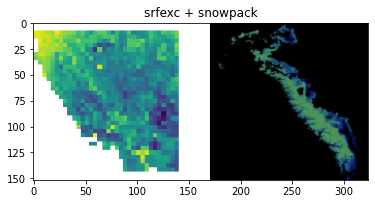

In [44]:
%%time
second_feature = 'rzmc
# Make training dataset
if multi_features == 1:
    X_data = np.reshape(np.array(all_data_df[second_feature][offset:train_size]), (train_size-offset, 1))
    for ix,iy in np.ndindex(X_data.shape):  
        X_data[ix,iy] = get_img_arr2(X_data[ix,iy], conv_snowcap_img(ix, 256, 256))

    
X_train = np.array(X_data.tolist())
X_train.shape
plt.title(str(str(second_feature) + ' + snowpack'))
plt.imshow(X_train[122][0])        


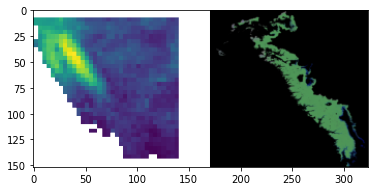

In [28]:
# Make test dataset
# multi_features = 1
if multi_features == 1:

    X_test_data = np.reshape(np.array(all_data_df[second_feature][train_size:]), (all_data_df.shape[0] - train_size, 1))
    for ix,iy in np.ndindex(X_test_data.shape):
        #X_data[ix,iy] = tf.image.resize(X_data[ix,iy], [img_height, img_width])
        X_test_data[ix,iy] = get_img_arr2(X_test_data[ix,iy], 
                            conv_snowcap_img((train_size-offset) + ix, 256, 256))

    X_test = np.array(X_test_data.tolist())
    plt.imshow(X_test[0][0])
    np.shape(X_test[0][0])

In [29]:
# if multi_features == 0:
#     X_data = np.reshape(np.array(all_data_df['Color_SCA_Image'][0:train_size]), (train_size, 1))
#     for ix,iy in np.ndindex(X_data.shape):
#         #X_data[ix,iy] = tf.image.resize(X_data[ix,iy], [img_height, img_width])
#         X_data[ix,iy] = np.array(X_data[ix,iy].resize((img_height, img_width)))
#     X_train = np.array(X_data.tolist())
#     X_train.shape

In [30]:

# model_savestr = str('base_model_' + str(second_feature))
# model_savestr

In [31]:
# pause = input()

## New (regional) models


In [32]:
%%time
# train_models = 0
if train_models == 0:
    Y_train = all_data_df['catdef'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    base_model = setup('base_model')
    base_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = base_model.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    # pred_base_model = get_predictions(all_data_df, base_model, test_months)
    pred = base_model.predict(X_test[0].reshape(1, 1, 152, 324, 4))
    quick_perf_base = quick_eval(mask_list(pred[0],flat_mask,9999), all_data_df['CA_catdef'][train_size])

    if save_models == 1:
        model_savestr = str('base_model_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        base_model.save(model_savestr)  
            
    del base_model

    tf.keras.backend.clear_session()
    clear_output(wait=True)
    print(quick_perf_base)

CPU times: user 31 µs, sys: 2 µs, total: 33 µs
Wall time: 15.3 µs


In [33]:
%%time
if train_models == 1:
    Y_train = all_data_df['catdef_region_1'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    model_1 = setup('model_1')
    model_1.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = model_1.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    pred_model_1 = get_predictions(all_data_df, model_1, test_months)
    # quick_perf_1 = quick_eval(mask_list(pred_model_1[0],flat_mask,9999), all_data_df['catdef_region_1'][train_size])

    if save_models == 1:
        model_savestr = str('model_1_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        model_1.save(model_savestr)  
            
            
    del model_1
    tf.keras.backend.clear_session()
    clear_output()
    # print(quick_perf_1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [34]:
%%time
if train_models == 2:
    Y_train = all_data_df['catdef_region_2'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    model_2 = setup('model_2')
    model_2.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = model_2.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    pred_model_2 = get_predictions(all_data_df, model_2, test_months)
    # quick_perf_2 = quick_eval(mask_list(pred_model_2[0],flat_mask,9999), all_data_df['catdef_region_2'][train_size])
    
    if save_models == 1:
        model_savestr = str('model_2_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        model_2.save(model_savestr)  
            
                    
    del model_2
    tf.keras.backend.clear_session()
    
    clear_output(wait=True)
    # print(quick_perf_2)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


In [35]:
%%time
if train_models == 3:
    Y_train = all_data_df['catdef_region_3'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    model_3 = setup('model_3')
    model_3.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = model_3.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    pred_model_3 = get_predictions(all_data_df, model_3, test_months)
    # quick_perf_3 = quick_eval(mask_list(pred_model_3[0],flat_mask,9999), all_data_df['catdef_region_3'][train_size])
    
    if save_models == 1:
        model_savestr = str('model_3_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        model_3.save(model_savestr)  
            
    del model_3

    tf.keras.backend.clear_session()
    clear_output(wait=True)
    # print(quick_perf_3)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [36]:
%%time
if train_models == 4:
   
    Y_train = all_data_df['catdef_region_4'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    model_4 = setup('model_4')
    model_4.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = model_4.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    # pred_model_4 = get_predictions(all_data_df, model_4, test_months)
    # quick_perf_4 = quick_eval(mask_list(pred_model_4[0],flat_mask,9999), all_data_df['catdef_region_4'][train_size])
    
    if save_models == 1:
        model_savestr = str('model_4_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        model_4.save(model_savestr)  
        
    del model_4
    tf.keras.backend.clear_session()

    clear_output(wait=True)
    # print(quick_perf_4)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [37]:
%%time
if train_models == 5:
    Y_train = all_data_df['catdef_region_5'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    model_5 = setup('model_5')
    model_5.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = model_5.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    # pred_model_5 = get_predictions(all_data_df, model_5, test_months)
    # quick_perf_5 = quick_eval(mask_list(pred_model_5[0],flat_mask,9999), all_data_df['catdef_region_5'][train_size])
    
    if save_models == 1:
        model_savestr = str('model_5_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        model_5.save(model_savestr)  
        
    del model_5
    tf.keras.backend.clear_session()
    clear_output(wait=True)
    # print(quick_perf_5)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


In [38]:
%%time
if train_models == 6:
    Y_train = all_data_df['catdef_region_6'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    model_6 = setup('model_6')
    model_6.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = model_6.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    # pred_model_6 = get_predictions(all_data_df, model_6, test_months)
    # quick_perf_6 = quick_eval(mask_list(pred_model_6[0],flat_mask,9999), all_data_df['catdef_region_6'][train_size])
    
    if save_models == 1:
        model_savestr = str('model_6_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        model_6.save(model_savestr)  
        
    del model_6
    tf.keras.backend.clear_session()
    clear_output(wait=True)
    # print(quick_perf_6)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [39]:
%%time
if train_models == 7:
    Y_train = all_data_df['catdef_region_7'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    model_7 = setup('model_7')
    model_7.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = model_7.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    # pred_model_7 = get_predictions(all_data_df, model_7, test_months)
    # quick_perf_7 = quick_eval(mask_list(pred_model_7[0],flat_mask,9999), all_data_df['catdef_region_7'][train_size])
    
    if save_models == 1:
        model_savestr = str('model_7_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        model_7.save(model_savestr)  
        
    del model_7
    tf.keras.backend.clear_session()
    clear_output(wait=True)
    # print(quick_perf_7) 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [40]:
%%time
if train_models == 8:
    Y_train = all_data_df['catdef_region_8'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    model_8 = setup('model_8')
    model_8.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = model_8.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    # pred_model_8 = get_predictions(all_data_df, model_8, test_months)
    # quick_perf_8 = quick_eval(mask_list(pred_model_8[0],flat_mask,9999), all_data_df['catdef_region_8'][train_size])
    
    if save_models == 1:
        model_savestr = str('model_8_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        model_8.save(model_savestr)  
        
    del model_8
    tf.keras.backend.clear_session()
    clear_output(wait=True)
    # print(quick_perf_8)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


In [41]:
%%time
if train_models == 9:
    Y_train = all_data_df['catdef_region_9'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    model_9 = setup('model_9')
    model_9.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = model_9.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    # pred_model_9 = get_predictions(all_data_df, model_9, test_months)
    # quick_perf_9 = quick_eval(mask_list(pred_model_9[0],flat_mask,9999), all_data_df['catdef_region_9'][train_size])
    
    if save_models == 1:
        model_savestr = str('model_9_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        model_9.save(model_savestr)  
        
    del model_9
    tf.keras.backend.clear_session()
    clear_output(wait=True)
    # print(quick_perf_9)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [42]:
%%time
if train_models == 10:
    Y_train = all_data_df['catdef_region_10'][0:train_size].map(lambda x: np.nan_to_num(x, nan=0).flatten()).tolist()
    model_10 = setup('model_10')
    model_10.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    history = model_10.fit(x=np.array(X_train, np.float32), y=np.array(Y_train, np.float32), validation_split=0.33, epochs=epochs, verbose=1)
    # pred_model_10 = get_predictions(all_data_df, model_10, test_months)
    # quick_perf_10 = quick_eval(mask_list(pred_model_10[0],flat_mask,9999), all_data_df['catdef_region_10'][train_size])
    
    if save_models == 1:
        model_savestr = str('model_10_' + str(second_feature))
        if multi_features == 0:
            model_savestr = str('models/' + model_savestr)
        if multi_features == 1:
            model_savestr = str('2_input_models/' + model_savestr)
        model_10.save(model_savestr)  
        
    del model_10
    tf.keras.backend.clear_session()
    clear_output(wait=True)
    # print(quick_perf_10)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [43]:
if stop == 1:
    stahp

# Compile predictions <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

In [44]:
 # model = tf.keras.models.load_model('2_input_models/original_model')

In [47]:
%%time

####  Concat prediction sets from all models into a single df

# all_the_predictions = pd.DataFrame()
# compile_predictions = 1
if compile_predictions == 1:
    if multi_features == 0:
            model_path = 'models/'
    if multi_features == 1:
            model_path = '2_input_models/'
    # model_names = ['original_model']
    # model_names = ['base_model_rzmc', 'model_1_rzmc', 'model_2_rzmc', 'model_3_rzmc', 'model_4_rzmc', 'model_5_rzmc', 'model_6_rzmc', 'model_7_rzmc', 'model_8_rzmc', 'model_9_rzmc', 'model_10_rzmc']
    # model_names = ['base_model_RainfC', 'model_1_RainfC', 'model_2_RainfC', 'model_3_RainfC', 'model_4_RainfC', 'model_5_RainfC', 'model_6_RainfC', 'model_7_RainfC', 'model_8_RainfC', 'model_9_RainfC', 'model_10_RainfC']
    # model_names = ['base_model_srfexc', 'model_1_srfexc', 'model_2_srfexc', 'model_3_srfexc', 'model_4_srfexc', 'model_5_srfexc', 'model_6_srfexc', 'model_7_srfexc', 'model_8_srfexc', 'model_9_srfexc', 'model_10_srfexc']
    model_names = ['base_model_evap', 'model_1_evap', 'model_2_evap', 'model_3_evap', 'model_4_evap', 'model_5_evap', 'model_6_evap', 'model_7_evap', 'model_8_evap', 'model_9_evap', 'model_10_evap']



    # model_names = ['original_model', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_10']

#     # model_names = ['base_model', 'model_1']
    start_predictions = pd.DataFrame()

    for i in tqdm(model_names):
        model_temp = pd.Series()
        model_temp.rename(str('model_temp_' + str(i)))
        load_model = str(model_path + i)
        model = tf.keras.models.load_model(load_model)
        if start_predictions.empty:
            start_predictions = get_predictions_mult(X_test, model, test_months)
        else: 
            add_predictions = get_predictions_mult(X_test, model, test_months)
            all_the_predictions = pd.concat([start_predictions, add_predictions], ignore_index=True)
            start_predictions = all_the_predictions
        del model
        tf.keras.backend.clear_session()
    clear_output()
    all_the_predictions
#     # # fig = plt.figure(figsize=(40,4))
#     # # plt.subplot(1,12,1)
#     # # plt.imshow(pred_base_model[26].reshape(33,37), cmap = 'winter')

CPU times: user 1min 12s, sys: 1min 31s, total: 2min 43s
Wall time: 6min 24s


In [48]:
all_the_predictions

,Month,Model,y_prediction
0,123,base_model_evap,"[3.862039, -3.3022914, 1.1359739, 94.85064, 12..."
1,124,base_model_evap,"[3.514492, -3.7944584, 1.6374869, 104.68668, 1..."
2,125,base_model_evap,"[3.5580626, -3.9784856, 2.0558534, 127.942924,..."
3,126,base_model_evap,"[4.3205433, -4.260375, 2.2176697, 186.0635, 23..."
4,127,base_model_evap,"[5.376707, -4.8499217, 2.6120586, 256.22867, 3..."
...,...,...,...
490,163,model_10_evap,"[0.061682865, 0.1175009, 0.04855023, -0.001473..."
491,164,model_10_evap,"[0.14317818, 0.062075227, 0.075431965, 0.04008..."
492,165,model_10_evap,"[0.20396121, 0.041110396, 0.06409045, 0.011932..."
493,166,model_10_evap,"[0.22053994, 0.12580007, 0.02049618, 0.0222972..."


# Load/save predictions

In [49]:
#### save compiled pred to .pkl

# compile_predictions = 1
if compile_predictions == 1:
    pred_savestr = str('all_predictions_' + str(second_feature) + '.pkl')
    if multi_features == 0:
         path = str('./data/' + pred_savestr)
    if multi_features == 1:
         path = str('./2_input_data/' + pred_savestr)
    with open(path, "wb") as fh:
      pickle.dump(all_the_predictions, fh)

In [50]:
###### Reload saved predictions (.pkl file)
compile_predictions = 1

if compile_predictions == 1:
    pred_savestr = str('all_predictions_' + str(second_feature) + ' (1).pkl')
    if multi_features == 0:
         path = str('./data/' + pred_savestr)
    if multi_features == 1:
         path = str('./2_input_data/' + pred_savestr)
    with open(path, "rb") as fh:
      loaded_predictions = pickle.load(fh)
    loaded_predictions.head(5)

In [51]:
loaded_predictions

,Month,Model,y_prediction
0,123,base_model_evap,"[3.862039, -3.3022914, 1.1359739, 94.85064, 12..."
1,124,base_model_evap,"[3.514492, -3.7944584, 1.6374869, 104.68668, 1..."
2,125,base_model_evap,"[3.5580626, -3.9784856, 2.0558534, 127.942924,..."
3,126,base_model_evap,"[4.3205433, -4.260375, 2.2176697, 186.0635, 23..."
4,127,base_model_evap,"[5.376707, -4.8499217, 2.6120586, 256.22867, 3..."
...,...,...,...
490,163,model_10_evap,"[0.061682865, 0.1175009, 0.04855023, -0.001473..."
491,164,model_10_evap,"[0.14317818, 0.062075227, 0.075431965, 0.04008..."
492,165,model_10_evap,"[0.20396121, 0.041110396, 0.06409045, 0.011932..."
493,166,model_10_evap,"[0.22053994, 0.12580007, 0.02049618, 0.0222972..."


In [ ]:
temp

# Save summaries

In [ ]:
# ####  Compare each prediction from a compiled df to the actual y values from the original df (.pkl)


# def evaluate_saved_preds(pred_df, data_df, months_array):
#     all_results = []
#     for month in months_array:
#         for region in range(1, 11):
#             for model in pred_df['Model'].unique():
            
#                 region_str = str('catdef_region_' + str(region))
#                 # print(month, region_str, model)
            
#                 # y_pred_model = pred_df['Model'][(pred_df['Model'] == model) & (pred_df['Month'] == month)]
#                 # y_pred_month = pred_df['Month'][(pred_df['Model'] == model) & (pred_df['Month'] == month)]
#                 y_pred = pred_df['y_prediction'][(pred_df['Model'] == model) & (pred_df['Month'] == month)]
                
#                 real_ca = np.nan_to_num(data_df['CA_catdef'][month], nan=0)
#                 real_region = np.nan_to_num(data_df[region_str][month], nan=0)
#                 pred_ca = np.nan_to_num(mask_list(y_pred.tolist()[0], flat_mask, 9999), nan = 0)
#                 pred_region = np.nan_to_num(mask_list(y_pred.tolist()[0], flat_mask, region), nan = 0)
#                 # print(pred_ca.shape)

                
# #             #### get actual y val for all catdef or region-specific catdef
#                 real_sum_ca = np.sum(real_ca)
#                 real_sum_region = np.sum(real_region)

#             # ####  Prediction.
#                 pred_sum_ca = np.sum(pred_ca)
#                 pred_sum_region = np.sum(pred_region)
                

            
#                 ca_accuracy = 1 - abs(real_sum_ca-pred_sum_ca)/real_sum_ca
#                 region_accuracy = 1 - abs(real_sum_region-pred_sum_region)/real_sum_region      
                
#                 ca_mape =  mean_absolute_percentage_error(real_ca, pred_ca.reshape(33,37))
#                 region_mape =  mean_absolute_percentage_error(real_region, pred_region.reshape(33,37))
                
          
#                 # print(y_pred)
# # 
            
# #             #### calc r-squared
#                 r2_ca = r2_score(np.nan_to_num(data_df['catdef'][month], nan=0), y_pred.tolist()[0].reshape(33,37))
#                 r2_region = r2_score(np.nan_to_num(data_df[region_str][month], nan=0), y_pred.tolist()[0].reshape(33,37))
        
#                 result_row = month, region_str, model, region_accuracy, region_mape, ca_accuracy, ca_mape, r2_ca, r2_region
#                 # print(result_row)
#                 all_results.append(result_row)
                

#     return all_results
# all_results = evaluate_saved_preds(loaded_predictions, all_data_df, test_months) 

In [ ]:
# all_preds_df = pd.DataFrame(all_results)
# # all_preds_df = all_preds_df.columns = ['month', 'x', 'n', 'v', 'CA_pred']
# all_preds_df = all_preds_df.rename(columns={0 : "Month", 1 : "Region", 2 : "Model", 3 : "Region_acc", 4 : "Region_mape", 5 : "CA_acc", 6 : "CA_mape", 7: "R2_CA", 8: "R2_reg"})
# # all_preds_df.sort_values(by = ['R2_CA'], ascending = False).head()

In [ ]:
# all_preds_df.sort_values('Region_acc', ascending = False).head()

In [ ]:
# original_CA = all_preds_df[all_preds_df['Model'] == 'original_model']
# np.average(original_CA.groupby('Region').mean()['CA_acc'])

In [ ]:
# base_CA = all_preds_df[all_preds_df['Model'] == 'base_model']
# np.average(base_CA.groupby('Region').mean()['CA_acc'])

In [ ]:
# all_best = []
# best_region = []
# for month in all_preds_df['Month'].unique():
#     for region in all_preds_df['Region'].unique():
#         test_df = all_preds_df[(all_preds_df['Month'] == month) & (all_preds_df['Region'] == region)]
#         best = max(test_df['Region_acc'])
#         model = test_df['Model'][test_df['Region_acc'] == best].iloc[0]
#         best_region = [month, region, best, model]
#         all_best.append(best_region)
# # all_best

In [ ]:
# best_preds_df = pd.DataFrame(all_best)
# # all_preds_df = all_preds_df.columns = ['month', 'x', 'n', 'v', 'CA_pred']
# best_preds_df = best_preds_df.rename(columns={0 : "Month", 1 : "Region", 2 : "Accuracy", 3 : "Model"})
# best_preds_df

In [ ]:
#  for region in best_preds_df['Region'].unique():
#         mcnt = best_preds_df[best_preds_df['Region'] == region]
#         cnt = mcnt['Model'][mcnt['Model'] != 'original_model'].value_counts().idxmax()
#         # cnt = mcnt['Model'].value_counts().idxmax()

#         print(str(region), cnt)
        
                             

# Check base accuracy

In [ ]:
## Check full set accuracy
mdl = ['original_model', 'base_model']
orig = []
base = []
for mnth in range(140, 168):
    orig_preds = loaded_predictions['y_prediction'][(loaded_predictions['Month'] == mnth) & (loaded_predictions['Model'] == mdl[0])].tolist()
    base_preds = loaded_predictions['y_prediction'][(loaded_predictions['Month'] == mnth) & (loaded_predictions['Model'] == mdl[1])].tolist()
    orig.append(quick_eval(mask_list(orig_preds, flat_mask, 9999), np.nan_to_num(all_data_df['CA_catdef'].iloc[mnth], nan=0).flatten()))
    base.append(quick_eval(base_preds, np.nan_to_num(all_data_df['catdef'].iloc[mnth], nan=0).flatten()))
clear_output()
compare_df = pd.DataFrame(orig, columns = [mdl[0]])
compare_df[mdl[1]] = (base)
compare_df['diff'] = compare_df[mdl[1]] - compare_df[mdl[0]]
compare_df
# print(mdl[1], 'improvement', np.sum(compare_df['diff']))
print('improvement', np.average(compare_df[mdl[1]]) - np.average(compare_df[mdl[0]]), np.average(compare_df[mdl[1]]), np.average(compare_df[mdl[0]]))

# Check feature importance


In [ ]:
catdef_region_sums = all_data_df.iloc[:,8:18]
orig_array = catdef_region_sums.columns
catdef_region_sums['Month'] = all_data_df['Data_month']

for col in orig_array:
    name = str(col + '_sum')
    catdef_region_sums[name] = catdef_region_sums[col].apply(lambda x: np.sum(np.nan_to_num(x, nan=0)))
catdef_region_sums

In [ ]:
#### save catdef sums to csv
catdef_region_sums_csv = catdef_region_sums.iloc[:,10:]
catdef_region_sums_csv['Month'] = catdef_region_sums['Month']
filepath = './2_input_data/catdef_region_sums.csv'  
catdef_region_sums_csv.to_csv(filepath)  

In [ ]:
catdef_region_sums_csv

In [ ]:
X = catdef_region_sums.iloc[:,10:].to_numpy()
Y = all_data_df['CA_catdef'].apply(lambda x: np.sum(np.nan_to_num(x))).astype(int)
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
# define dataset
# X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X, Y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(X, Y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, Y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
plt.savefig('feature_importance.png')

# Find regions that outperform the original model

In [ ]:
fig = plt.figure(figsize= (80,80))
month_range = np.arange(144,156)
plotme = []
nameme = []
maxerr = 0
minerr = 0
model_names = ['original_model', 'base_model', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_10']


# # establish error of original model
# for month in month_range:
#         o_month_pred = loaded_predictions[(loaded_predictions['Model'] == 'base') & (loaded_predictions['Month'] == month)]['y_prediction'].tolist()
#         o_month_pred_ca = mask_list(month_pred, flat_mask, 9999)
#         o_error = all_data_df['CA_catdef'][month].flatten() - np.nan_to_num(month_pred_ca, nan=0)
#         # print(error)

# compare other models to original
for model in model_names:
    for month in month_range:
        
        o_month_pred = loaded_predictions[(loaded_predictions['Model'] == 'base_model') & (loaded_predictions['Month'] == month)]['y_prediction'].tolist()
        o_month_pred_ca = mask_list(o_month_pred, flat_mask, 9999)
        o_error = abs(all_data_df['CA_catdef'][month].flatten() - np.nan_to_num(o_month_pred_ca, nan=0))
        
        
        
        month_pred = loaded_predictions[(loaded_predictions['Model'] == model) & (loaded_predictions['Month'] == month)]['y_prediction'].tolist()
        month_pred_ca = mask_list(month_pred, flat_mask, 9999)
        error = -1 * abs((all_data_df['CA_catdef'][month].flatten() - np.nan_to_num(month_pred_ca, nan=0)))
        # maxerr0 = max(np.nan_to_num(error, nan=0))
        # minerr0 = min(np.nan_to_num(error, nan=0))
        # if maxerr0 > maxerr:
        #     maxerr = maxerr0
        # if minerr0 > minerr:
        #     minerr = minerr0
        # for i in range(len(error)):
        #     if error[i] > o_error[i]:
        #         error[i] = None
            
        # print(error)
        # error = mask_list(error[0], flat_mask, 9999)
        
        title = str(str(model) + ' ' + str(month))
        plotme.append(error)
        nameme.append(title)

for i in range(1, len(model_names)*len(month_range)+1):
    plt.subplot(13,12,i)
    plt.title(nameme[i-1], fontsize = 20)
    plt.imshow(plotme[i-1].reshape(33,37), cmap='RdYlGn')

    plt.text(.5, .5, i)
    


In [ ]:
loaded_predictions[(loaded_predictions['Model'] == 'model_1_RanfC') & (loaded_predictions['Month'] == 140)]['y_prediction'].tolist()

In [ ]:
loaded_predictions

In [ ]:
# model_region_dict = {
#     1:'base_model',
#     2:'model_2',
#     3:'base_model',
#     4:'base_model',
#     5:'model_5',
#     6:'model_6',
#     7:'base_model',
#     8:'base_model',
#     9:'base_model',
#     10:'model_10'     
# }
model_region_dict = {
    1:'base_model',
    2:'base_model',
    3:'base_model',
    4:'base_model',
    5:'base_model',
    6:'base_model',
    7:'base_model',
    8:'base_model',
    9:'base_model',
    10:'base_model'     
}

In [ ]:
mix_n_match = []
mixed_df = pd.DataFrame()
mixed_df['Month'] = test_months
# mixed_df['mixed_predictions'] = []
for i in range(train_size, len(all_data_df)):
#     # print(i)
#     # base_row = base_df[i]
#     # print(loaded_predictions['Month'][i])
    mix_n_match.append(sampler(loaded_predictions, model_region_dict, i))
    
mixed_df['Model'] = 'mixed_models'
mixed_df['y_prediction'] = mix_n_match
# mixed_df['mixed_sums'] = mixed_df['y_prediction'].apply(lambda x: np.sum(x))

# add mixed_df to loaded_predictions
predictions_plus_mixed = pd.concat([mixed_df, loaded_predictions], ignore_index = True)
predictions_plus_mixed['y_masked'] = predictions_plus_mixed['y_prediction'].apply(lambda x: np.nan_to_num(mask_list(x, flat_mask, 9999), nan=0))
predictions_plus_mixed.head()

In [ ]:
## Check full accuracy for mixed_df
offset = 8
mdl = ['original_model', 'mixed_models']
orig = []
mix = []
for mnth in range(140, 168):
    original_preds = np.nan_to_num(mask_list(predictions_plus_mixed['y_masked'][(predictions_plus_mixed['Month'] == mnth) & (predictions_plus_mixed['Model'] == mdl[0])].tolist(), flat_mask, 9999), nan=0)
    # mixed_preds = np.nan_to_num(mask_list(mixed_df['y_prediction'][(loaded_predictions['Month'] == mnth)].tolist(), flat_mask, 9999), nan=0)
    mixed_preds =  np.nan_to_num(mask_list(predictions_plus_mixed['y_masked'][(predictions_plus_mixed['Month'] == mnth) & (predictions_plus_mixed['Model'] == mdl[1])].tolist(), flat_mask, 9999), nan=0)
    orig.append(quick_eval(original_preds, np.nan_to_num(all_data_df['CA_catdef'].iloc[mnth], nan=0).flatten()))
    mix.append(quick_eval(mixed_preds, np.nan_to_num(all_data_df['CA_catdef'].iloc[mnth], nan=0).flatten()))
clear_output()
compare_df = pd.DataFrame(orig, columns = [mdl[0]])
compare_df[mdl[1]] = (mix)
compare_df['diff'] = compare_df[mdl[1]] - compare_df[mdl[0]]
compare_df
# print(mdl[1], 'improvement', np.sum(compare_df['diff']))
print('improvement', np.average(compare_df[mdl[1]]) - np.average(compare_df[mdl[0]]), np.average(compare_df[mdl[1]]), np.average(compare_df[mdl[0]]))

In [ ]:
# aaa = loaded_predictions['y_prediction'][(loaded_predictions['Model'] == 'base_model') & (loaded_predictions['Month'] == 123)][45].astype(int)

In [ ]:
# bbb = np.array(predictions_plus_mixed['y_prediction'].iloc[0]).astype(int)

In [ ]:
for i in range(len(aaa)):
    print(aaa[i], bbb[i])

In [ ]:
#### save compiled pred to .pkl

# compile_predictions = 1
if compile_predictions == 1:
    if multi_features == 0:
         path = './data/predictions_plus_mixed.pkl'
    if multi_features == 1:
         path = './2_input_data/predictions_plus_mixed.pkl'
    with open(path, "wb") as fh:
      pickle.dump(predictions_plus_mixed, fh)

In [ ]:
predictions_plus_mixed

In [ ]:
#### save output to ensemble
overwrite_ensemble_output = 1
if overwrite_ensemble_output == 1:
        output_grid_predictions = loaded_predictions_full[loaded_predictions_full['Model'] == 'mixed_models']
        output_grid_predictions['predicted_catdef'] = output_grid_predictions['y_masked']
        output_grid_predictions = output_grid_predictions.drop(['y_prediction', 'Model', 'y_masked'], axis = 1)

        filepath_out = './out_to_ensemble/convlstm_predictions.pkl'
        with open(filepath_out, "wb") as fh:
            pickle.dump(output_grid_predictions, fh)

        with open(filepath_out, "rb") as fh:
            output_grid_predictions = pickle.load(fh)

In [ ]:
# check output to ensemble

filepath_out = './out_to_ensemble/convlstm_predictions.pkl'
with open(filepath_out, "rb") as fh:
    output_grid_predictions_l = pickle.load(fh)
output_grid_predictions_l.head(5)

# Plot sums

In [ ]:
# predicted_sums = loaded_predictions.copy()
predicted_sums =  predictions_plus_mixed.copy()
predicted_sums['y_sum'] = predicted_sums['y_prediction'].apply(lambda x: np.sum(x))
predicted_sums['y_masked_sum'] = predicted_sums['y_masked'].apply(lambda x: np.sum(x))
predicted_sums = predicted_sums.drop(['y_prediction'], axis = 1)
predicted_sums['mask_diff'] = predicted_sums['y_sum'] - predicted_sums['y_masked_sum']


In [ ]:
test_len = len(predicted_sums['Month'].unique())

for model in predicted_sums['Model'].unique():
    nametag = str(model + '_sum')
    model_sums = predicted_sums['y_sum'][predicted_sums['Model'] == model]
    predicted_sums[nametag] = 0
    predicted_sums[nametag][:test_len] = model_sums
    
    maskname = str(model + '_mask_sum')
    masked_sums = predicted_sums['y_masked_sum'][predicted_sums['Model'] == model]
    predicted_sums[maskname] = 0
    predicted_sums[maskname][:test_len] = masked_sums
    
predicted_sums = predicted_sums[:test_len]
   
predicted_sums.head()

In [ ]:
start_mo = min(predicted_sums['Month'].unique())
stop_mo = max(predicted_sums['Month'].unique())
cacatdef = all_data_df['CA_catdef'][start_mo:stop_mo + 1].apply(lambda x: np.sum(np.nan_to_num(x,nan=0)))
catdef = all_data_df['catdef'][start_mo:stop_mo + 1].apply(lambda x: np.sum(np.nan_to_num(x,nan=0)))

predicted_sums['CA_catdef'] = cacatdef.tolist()
predicted_sums['catdef'] = catdef.tolist()

predicted_sums.head(2)

In [ ]:
#### save compiled sums to csv
predicted_sums_csv = predicted_sums.drop(['y_masked'], axis = 1)
filepath = './2_input_data/predicted_sums.csv'  
predicted_sums_csv.to_csv(filepath)  

In [ ]:
ensemble_output

In [ ]:
predicted_sums.plot(x="Month", y=['catdef',  'original_model_sum','CA_catdef' ,'original_model_mask_sum'], figsize = (30, 10), cmap = mpl.colors.ListedColormap(['black', 'red', 'black', 'green']))

In [ ]:
fig = predicted_sums.plot(x="Month", y=['CA_catdef', 'original_model_mask_sum', 'mixed_models_mask_sum'], figsize = (30, 10), cmap = mpl.colors.ListedColormap(['black', 'red', 'green']))
fig.plot(predicted_sums['Month'], predicted_sums['mixed_models_mask_sum'], lw = 4, c = 'green')

In [ ]:
new_sums = predicted_sums_csv.copy()
new_sums = new_sums.iloc[:,8:34:2]
new_sums['Month'] = predicted_sums_csv['Month']
new_sums.head(2)

In [ ]:
new_cat_sums = catdef_region_sums_csv.copy()
new_cat_sums = new_cat_sums.iloc[140:,:]
new_cat_sums['Month'] = catdef_region_sums_csv['Month']
new_cat_sums.reset_index(drop = True)
new_cat_sums.head(2)

In [ ]:
region_sum_composite = pd.merge(new_sums, new_cat_sums, on='Month')
region_sum_composite

In [ ]:
acc_array = []
for i in range(1,11):
    mskstr = str('model_' + str(i) + '_mask_sum')
    cdstr = str('catdef_region_' + str(i) + '_sum')
    msk_sum = np.sum(region_sum_composite[mskstr])
    cd_sum =  np.sum(region_sum_composite[cdstr])
    acc = 1 - ((abs(msk_sum-cd_sum))/cd_sum)
    acc_array.append(round(acc*100, 1))
acc_array

In [ ]:
height = 25
fig, axs = plt.subplots(10, figsize = (20, height))
fig.suptitle('Region accuracy\n', fontsize = height*2)
fig.tight_layout(pad=3)


for i in range(1,11):
    mskstr = str('model_' + str(i) + '_mask_sum')
    cdstr = str('catdef_region_' + str(i) + '_sum')
    title = str('Region ' + str(i) + ': ' + str(acc_array[i-1]) + '%')
    # axs[i-1].title.set_text(title, fontdict={'fontsize': height*.8, 'fontweight': 'medium'})
    axs[i-1].set_title(title, fontsize = height*1.5, position = (.1,0))
    # axs[i-1].set_ylim([0, 45000])
    axs[i-1].plot(region_sum_composite['Month'], region_sum_composite[mskstr], c = 'red')
    axs[i-1].plot(region_sum_composite['Month'], region_sum_composite[cdstr], c = 'black')


In [ ]:
loaded_predictions2 = loaded_predictions.copy()
loaded_predictions2 = pd.concat([loaded_predictions, mixed_df], sort=False)

In [ ]:
loaded_predictions2

In [ ]:
cur_time = time.time()
print(int(cur_time-start_time)/60)

In [ ]:
# now_with_predictions.tail(25)

In [ ]:
model_names2 = ['mixed_models', 'base_model', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_10']

fig = plt.figure(figsize= (80,80))
month_range = np.arange(144,156)
plotme = []
nameme = []
maxerr = 0
minerr = 0

# # establish error of original model
# for month in month_range:
#         o_month_pred = loaded_predictions[(loaded_predictions['Model'] == 'base') & (loaded_predictions['Month'] == month)]['y_prediction'].tolist()
#         o_month_pred_ca = mask_list(month_pred, flat_mask, 9999)
#         o_error = all_data_df['CA_catdef'][month].flatten() - np.nan_to_num(month_pred_ca, nan=0)
#         # print(error)

# compare other models to original
for model in model_names2:
    for month in month_range:
        
        o_month_pred = loaded_predictions2[(loaded_predictions2['Model'] == 'base_model') & (loaded_predictions2['Month'] == month)]['y_prediction'].tolist()
        o_month_pred_ca = mask_list(o_month_pred, flat_mask, 9999)
        o_error = abs(all_data_df['CA_catdef'][month].flatten() - np.nan_to_num(o_month_pred_ca, nan=0))
        
        
        
        month_pred = loaded_predictions2[(loaded_predictions2['Model'] == model) & (loaded_predictions2['Month'] == month)]['y_prediction'].tolist()
        month_pred_ca = mask_list(month_pred, flat_mask, 9999)
        error = o_error - abs((all_data_df['CA_catdef'][month].flatten() - np.nan_to_num(month_pred_ca, nan=0)))
        # maxerr0 = max(np.nan_to_num(error, nan=0))
        # minerr0 = min(np.nan_to_num(error, nan=0))
        # if maxerr0 > maxerr:
        #     maxerr = maxerr0
        # if minerr0 > minerr:
        #     minerr = minerr0
        # for i in range(len(error)):
        #     if error[i] > o_error[i]:
        #         error[i] = None
            
        # print(error)
        # error = mask_list(error[0], flat_mask, 9999)
        
        title = str(str(model) + ' ' + str(month))
        plotme.append(error)
        nameme.append(title)

for i in range(1, len(model_names)*len(month_range)+1):
    plt.subplot(13,12,i)
    plt.title(nameme[i-1], fontsize = 20)
    plt.imshow(plotme[i-1].reshape(33,37), cmap='RdYlGn')

    plt.text(.5, .5, i)

# Testing

********************